# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


# read in the json files
portfolios = pd.read_json('portfolio.json', orient='records', lines=True)
profiles = pd.read_json('profile.json', orient='records', lines=True)
transcripts = pd.read_json('transcript.json', orient='records', lines=True)

# i) Data Exploration

## 1. Exploring the Portfolio dataframe

In [6]:
portfolios.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
print("portfolio: Rows = {0}, Columns = {1}".format(str(portfolios.shape[0]), str(portfolios.shape[1])))

portfolio: Rows = 10, Columns = 6


In [8]:
portfolios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [9]:
portfolios.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [11]:
def horizontal_bar_plots(df, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltfigsize: The figure size of the plot (default is [5,5]).
    
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntSize: The font size of text (default to 12 point font size)
    
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

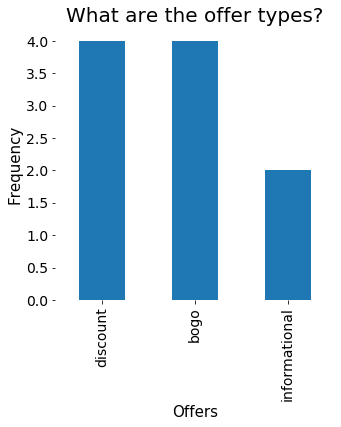

In [12]:
ax = portfolio["offer_type"].value_counts().plot.bar(
    figsize=(5,5),
    fontsize=14,

)

ax.set_title("What are the offer types?", fontsize=20)
ax.set_xlabel("Offers", fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
sns.despine(bottom=True, left=True)

<Figure size 360x360 with 0 Axes>

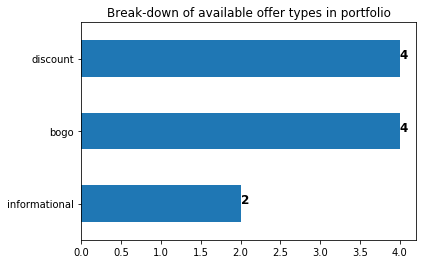

In [13]:
horizontal_bar_plots(portfolios, 'offer_type', "Break-down of available offer types in portfolio")

<Figure size 360x360 with 0 Axes>

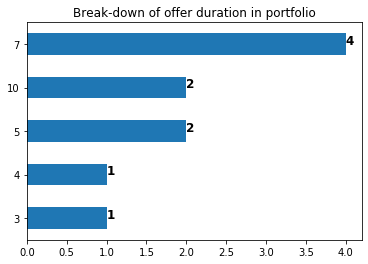

In [14]:
horizontal_bar_plots(portfolios, 'duration', "Break-down of offer duration in portfolio")

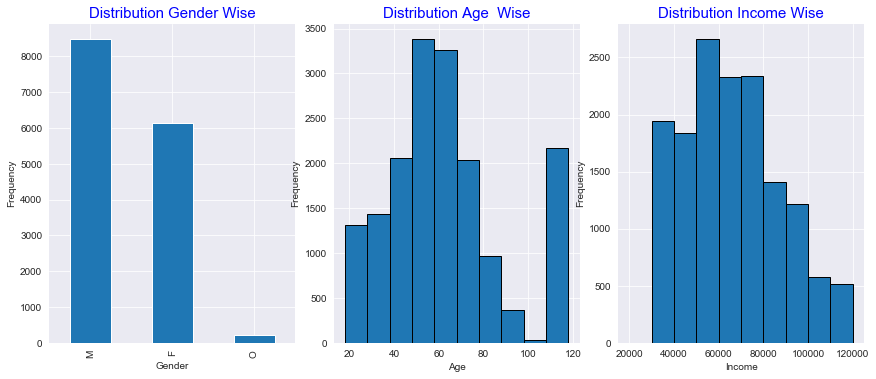

In [15]:
#Creating Subplots for distribution based on Gender,Age and Income
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,3,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()
# GENDER BASED
profile.gender.value_counts().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Distribution Gender Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Gender", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)


# AGE BASED
profile.age.plot.hist(ax=ax[1],fontsize=10,edgecolor='black') 
ax[1].set_title("Distribution Age  Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Age", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
profile.income.plot.hist(ax=ax[2],fontsize=10,edgecolor='black',range=(20000, 120000)) 
ax[2].set_title("Distribution Income Wise", fontsize=15,color='blue')
ax[2].set_xlabel("Income", fontsize=10)
ax[2].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()



## 2. Exploring the Profile dataframe

In [16]:
profiles.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [17]:
print("profile: Rows = {0}, Columns = {1}".format(str(profiles.shape[0]), str(profiles.shape[1])))

profile: Rows = 17000, Columns = 5


In [18]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [20]:
profiles.describe(include="all")

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,90b9b612883340d683fdc1979dd79831,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


In [21]:
#check for null values 
profiles.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [22]:
profiles[profiles['age']== 118].age.count()

2175

According to the description of the profile data frame and checking null values, it looks like values of gender & income are missing where age is 118. To confirm, I'll print the values with age 118.

In [23]:
profiles[profiles['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


Thus, it is confirmed that both gender & income for the age 118 are missing. All missing age values are encoded as 118.

### 2.a. Analysing the age values in the profile dataframe

In [25]:
#check for different age values
profiles.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [24]:
#check for age above 80 and less than 118 
profiles[(profiles['age'] > 80) & (profiles['age'] < 118)]

,gender,age,id,became_member_on,income
33,F,96,868317b9be554cb18e50bc68484749a2,20171117,89000.0
94,F,89,4264b1d027cc493281bba4f44bfedaca,20171114,87000.0
98,F,90,1c587de019994f93a242c6864fd7bc55,20151210,98000.0
126,M,83,4c29d22467af4d7faa137c4eedd65340,20180127,46000.0
131,F,89,3dae0eadb47149b0b9b548d14548524b,20180114,65000.0
...,...,...,...,...,...
16914,M,87,d1c4500ace2e45e9a45d3cd2fccac8d8,20140920,59000.0
16933,M,85,a65353ea28ff442aabfb39eb974326e3,20161001,96000.0
16938,F,89,da7bf9d84fd74a72bdee595007bcca7a,20170413,68000.0
16981,M,84,1966fa40d2f84620b2b1b9b64f8e0209,20160629,93000.0


Let us create a boxplot to find the outliers in our data frame

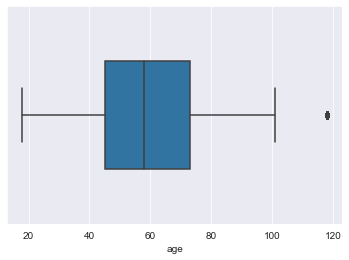

In [26]:
sns.boxplot(profiles['age'], width=0.5);

In [27]:
def exploded_pie_plots(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

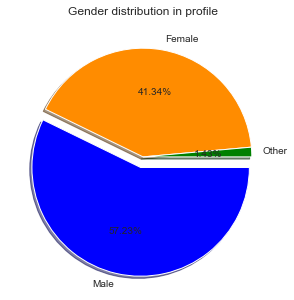

In [28]:
exploded_pie_plots(profiles, 'gender', 'Gender distribution in profile', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

It seems to be like people with age greater than 80 don't use the app much or they may not drink much beverages. So, I consider people with the above age as outliers.

### 2.b. Gender counts in the profile dataframe

<Figure size 360x360 with 0 Axes>

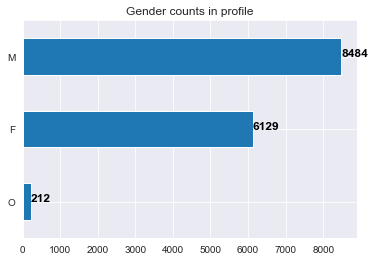

In [32]:
horizontal_bar_plots(profiles, 'gender', "Gender counts in profile")

In [30]:
def exploded_pie_plot(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

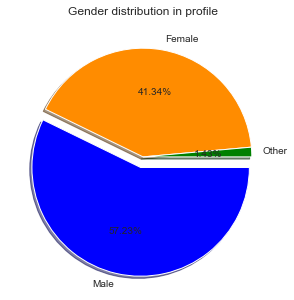

In [31]:
exploded_pie_plot(profiles, 'gender', 'Gender distribution in profile', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

## 3. Exploring the Transcript dataframe

In [33]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [34]:
print("transcript: Rows = {0}, Columns = {1}".format(str(transcript.shape[0]), str(transcript.shape[1])))

transcript: Rows = 306534, Columns = 4


In [36]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [37]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [39]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

It can be seen that there are 4 possible values: 'offer id', 'offer_id', 'reward' and 'amount', out of which 'offer id' and 'offer_id' are to be considered same.

In [41]:
transcript.describe(include="all")

,person,event,value,time
count,306534,306534,306534,306534.000000
unique,17000,4,5121,NaN
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN
freq,51,138953,14983,NaN
mean,NaN,NaN,NaN,366.382940
std,NaN,NaN,NaN,200.326314
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,186.000000
50%,NaN,NaN,NaN,408.000000
75%,NaN,NaN,NaN,528.000000


<Figure size 360x360 with 0 Axes>

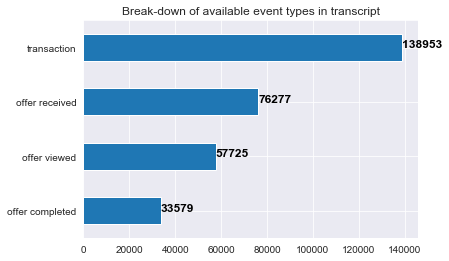

In [43]:
horizontal_bar_plots(transcript, 'event', "Break-down of available event types in transcript")

# ii) Data Preparation and Cleaning

## 1. Cleaning Portfolio

Renaming some columns for better readability & easiness in merging dataframes later.

In [2]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_cols_name)
    return df

In [3]:
#rename columns
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolios, new_cols_name )

In [4]:
cleaned_portfolio.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [5]:
cleaned_portfolio.columns

Index(['offer_reward', 'channels', 'offer_difficulty', 'offer_duration',
       'offer_type', 'offer_id'],
      dtype='object')

## 2. Cleaning Profile

#### Tasks:
1. Renaming some columns for better readability & easiness in merging dataframes later.<br />
2. In order to not lose data with null values, it is better to impute them. So, I will consider imputing missing age & income values with mean and missing gender values with mode.<br />
3. Considering people with age above 80 as outliers, remove them from the dataset.
4. Classifying ages into groups for better understanding in Exploratory Data Analysis later:
    * Under 20
    * 20 - 45
    * 46 - 60
    * 61 - 80

In [12]:
#rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profiles = rename_cols(profiles, cols_profile )

In [13]:
cleaned_profiles.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'customer_income'], dtype='object')

In [14]:
def cleaning_profiles(df):
    """
    Clean the profile data frame as per tasks 2-4
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per tasks
    """
    
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df.replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [15]:
cleaned_profiles = cleaning_profiles(cleaned_profiles)

In [16]:
cleaned_profiles.head()

,gender,customer_id,became_member_on,customer_income,Age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60
2,M,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,61-80
4,M,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,46-60


In [60]:
cleaned_profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
gender              16014 non-null object
customer_id         16014 non-null object
became_member_on    16014 non-null int64
customer_income     16014 non-null float64
Age_group           16014 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [61]:
#check for missing values 
cleaned_profiles.isnull().sum()

gender              0
customer_id         0
became_member_on    0
customer_income     0
Age_group           0
dtype: int64

In [62]:
cleaned_profiles.shape

(16014, 5)

Cleaning profile data frame is complete and now we don't have any null values.

## 3. Cleaning Transcript

#### Tasks:
1. Renaming some columns for better readability & easiness in merging dataframes later.<br />
2. Expand the keys of the 'value' column into new columns.

In [18]:
#rename columns
transcript_cols = {'person':'customer_id'}
cleaned_transcript = rename_cols(transcripts, transcript_cols)

In [19]:
cleaned_transcript.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

In [20]:
def cleaning_transcript(df):
    """
    Cleaning the transcript data frame as per task 2.
    
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per task
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [21]:
cleaned_transcript = cleaning_transcript(cleaned_transcript)

In [22]:
cleaned_transcript.head()

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [68]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
customer_id     306534 non-null object
event           306534 non-null object
time            306534 non-null int64
offer_id        306534 non-null object
money_gained    306534 non-null float64
money_spent     306534 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


# iii) Exploratory Data Analysis (EDA)

## Merging data frames for EDA

In [23]:
def merge_data_info(portfolio,profile,transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [26]:
merged_df = merge_data_info(cleaned_portfolio, cleaned_profiles, cleaned_transcript)

In [27]:
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


### The final combined data frame is ready for EDA. Let us analyze this data to find its representations & characteristics.

In [74]:
merged_df

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157498,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,12f7dc81c39a4db59177faaa1769a0dc,offer received,504,0.0,0.0,M,20170704,45000.0,20-45
157499,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,12f7dc81c39a4db59177faaa1769a0dc,offer viewed,504,0.0,0.0,M,20170704,45000.0,20-45
157500,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,12f7dc81c39a4db59177faaa1769a0dc,offer completed,630,2.0,0.0,M,20170704,45000.0,20-45
157501,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,offer received,576,0.0,0.0,M,20170820,44000.0,46-60


### 1. Average income of customers using the app

In [75]:
merged_df['customer_income'].mean()

65924.49109976116

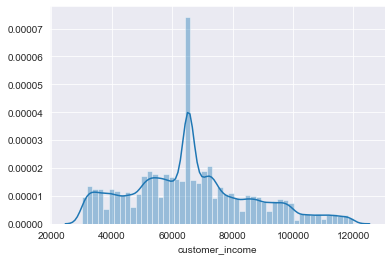

In [76]:
sns.distplot(merged_df['customer_income'], bins=50, hist_kws={'alpha': 0.4});

### 2. Most used offer by the customers

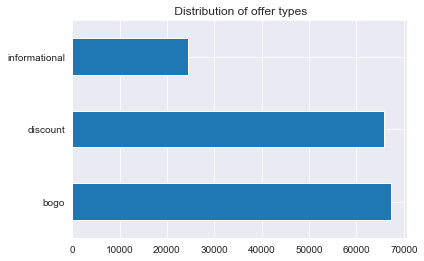

In [77]:
merged_df['offer_type'].value_counts().plot.barh(title=' Distribution of offer types')

BOGO and discount offers have nearly the same distributions

### 3. Age distribution of customers

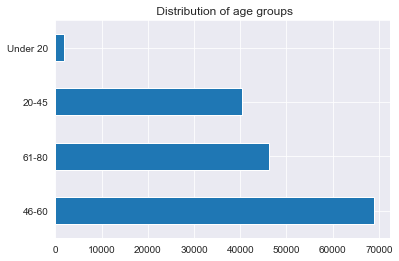

In [78]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')

It is quite surprising to see that customers with age 46-60 use Starbucks application the most, those with age 61-80 are on the second. One would usually think that customers between age 20-45 use app the most, but this is not the case here.

### 4. Actions to the offers that customers received

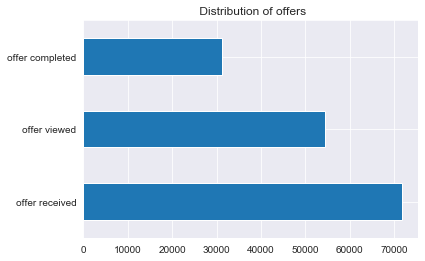

In [79]:
merged_df['event'].value_counts().plot.barh(title=' Distribution of offers')

This implies most of the customers don't pay attention to the offer, don't even have a look at it. Also, there are more number of customers who just view & ignore the offer than the one's who actually complete the offer.

For a better analysis, let us analyze the data based on gender.

### 5. Distribution of males & females

In [81]:
plot_genders = merged_df[merged_df['gender'] != 'O']

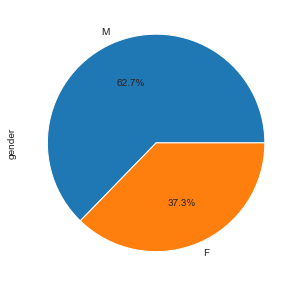

In [82]:
plot_genders.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

### 6. Age group of males & females

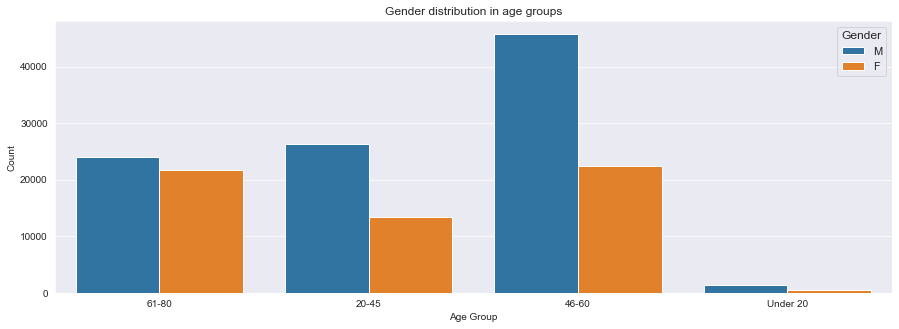

In [83]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

The male customers are more than the female ones in each age group.

### 7. Gender distribution in each offer type

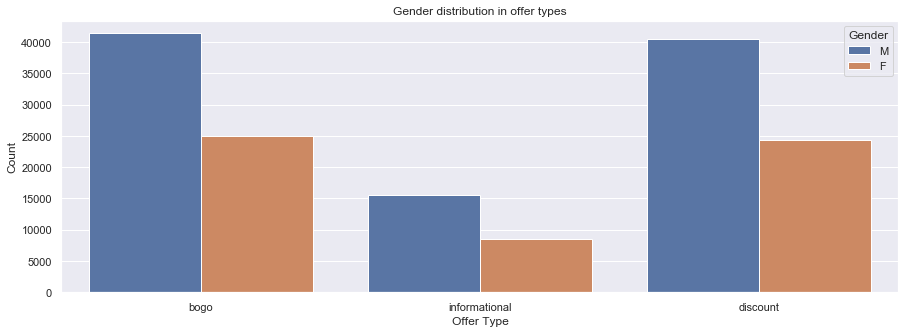

In [84]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

### 8. Actions to the offers that males & females received

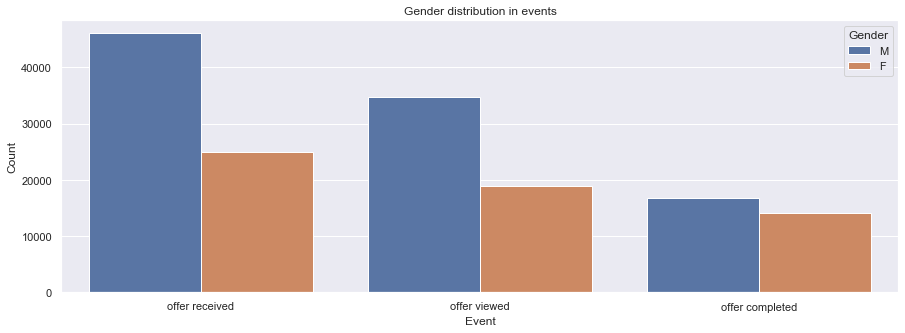

In [85]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

### 9. Actions to the offers in each offer type

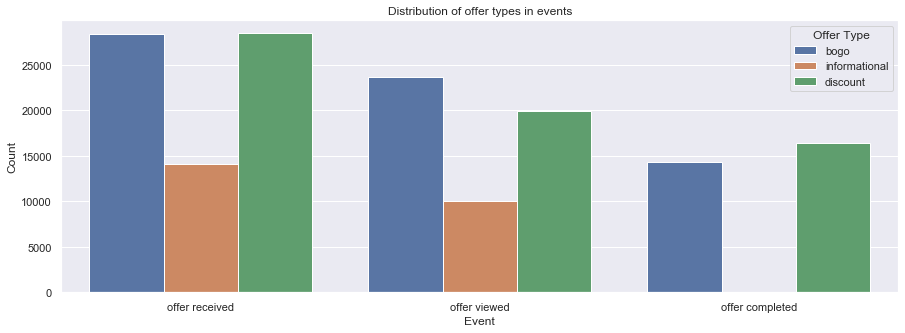

In [86]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

In general, most people take the discount offer.

### 10. Actions to the offers in each age group

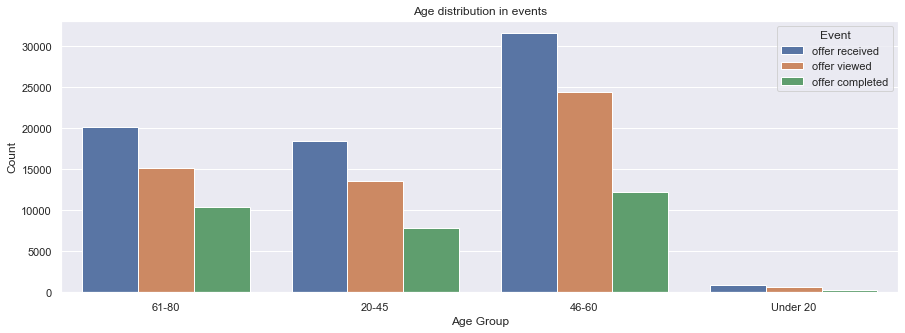

In [87]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

# iv) Build a Machine Learning model to predict response of a customer to an offer

Before building a model, we'll have to clean & prepare the data to fit into the model.

## 1. Data Preparation and Cleaning II

In [39]:
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


In [38]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
offer_reward        157503 non-null int64
channels            157503 non-null object
offer_difficulty    157503 non-null int64
offer_duration      157503 non-null int64
offer_type          157503 non-null object
offer_id            157503 non-null object
customer_id         157503 non-null object
event               157503 non-null object
time                157503 non-null int64
money_gained        157503 non-null float64
money_spent         157503 non-null float64
gender              157503 non-null object
became_member_on    157503 non-null int64
customer_income     157503 non-null float64
Age_group           157503 non-null object
dtypes: float64(3), int64(5), object(7)
memory usage: 24.2+ MB


#### Tasks
1. Encode categorical data such as gender, offer type, channel and age groups.
2. Encode the 'event' data to numerical values:
    * offer received ---> 1
    * offer viewed ---> 2
    * offer completed ---> 3
3. Encode offer id and customer id.
4. Drop column 'became_member_on' and add separate columns for month and year.
5. Scale and normalize numerical data.

In [28]:
def cleaning_final_data_info(df):
    """
    Clean merged data frame for the final data as per tasks 1-5.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [36]:
cleaned_data = cleaning_final_data_info(merged_df)

In [37]:
cleaned_data.head(10)

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,1.0,0.5,0.571429,0,0,1,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,1.0,0.5,0.571429,0,0,2,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,1.0,0.5,0.571429,0,0,1,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,1.0,0.5,0.571429,0,0,2,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,1.0,0.5,0.571429,0,0,3,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
5,0.0,0.0,0.142857,1,0,1,0.571429,0.0,0.0,0.777778,...,0,0,1,0,1,1,0,1,9,2017
6,0.0,0.0,0.142857,1,0,2,0.655462,0.0,0.0,0.777778,...,0,0,1,0,1,1,0,1,9,2017
7,0.5,1.0,1.000000,2,0,1,0.235294,0.0,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017
8,0.5,1.0,1.000000,2,0,2,0.243697,0.0,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017
9,0.5,1.0,1.000000,2,0,3,0.252101,0.5,0.0,0.777778,...,0,0,1,0,1,0,0,1,9,2017


In [40]:
cleaned_data.columns

Index(['offer_reward', 'offer_difficulty', 'offer_duration', 'offer_id',
       'customer_id', 'event', 'time', 'money_gained', 'money_spent',
       'customer_income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'email', 'mobile', 'social', 'web',
       'month_member', 'year_member'],
      dtype='object')

In [41]:
cleaned_data.shape

(157503, 26)

In [42]:
cleaned_data.event.value_counts()

1    71863
2    54396
3    31244
Name: event, dtype: int64

## 2. Split train and test data

Final data is ready after tasks 1-5. We will now split the data (both features and their labels) into training and test sets, taking 60% of data for training and 40% for testing.

In [43]:
data = cleaned_data.drop('event', axis=1)
label = cleaned_data['event']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 94501 rows
Testing set: 63002 rows


## 3. Training and Testing

### Metrics

We will consider the F1 score as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [46]:
def train_test_model(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

### KNeighborsClassifier (Benchmark)

We use the K-Nearest Neighbors algorithm to build the benchmark, and evaluate the model result by the F1 score metric.

In [47]:
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test_model(clf_A)

In [48]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [49]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,54.346515,32.891019


### RandomForestClassifier

In [50]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [52]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[b_train_f1], 'test F1 score': [b_test_f1]}
benchmark = pd.DataFrame(knn)
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,94.459318,70.702517


### DecisionTreeClassifier

In [53]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)
knn = {'Benchmark Model': [ c_model], 'train F1 score':[c_train_f1], 'test F1 score': [c_test_f1]}
benchmark = pd.DataFrame(knn)
benchmark

,Benchmark Model,train F1 score,test F1 score
0,DecisionTreeClassifier,95.455075,85.079839


# v) Conclusions

## 1. EDA

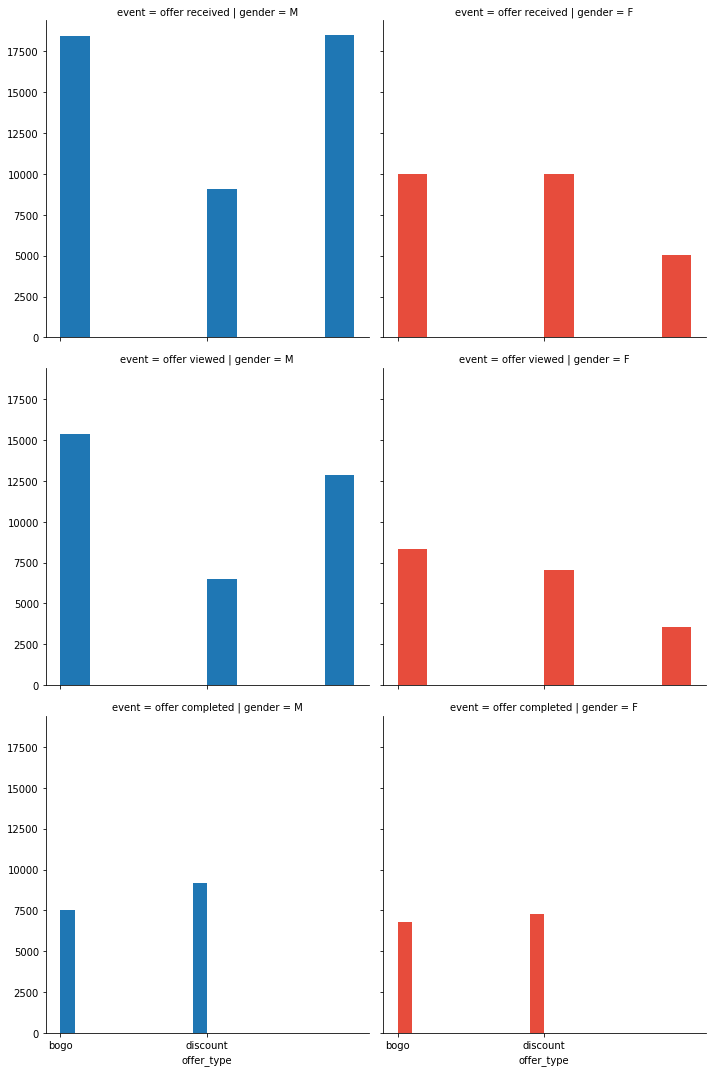

In [57]:
d = {'color': ['C0', "#e74c3c"]}
plot_genders = merged_df[merged_df['gender'] != 'O']
g = sns.FacetGrid(plot_genders, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

The males represent 62.7% of the data and use the Starbucks app more than the females. Specifically, both males & females in the age group 46-60 use app the most. Discount offers are more preferred by the customers. Also, there are less number of customers who actually complete the offer as compared to the ones who just view & ignore it. We can look more to the figures & information in section- iii) Exploratory Data Analysis (points 1-10) to best determine which kind of offers to send to the customers.

## 2. Model comparisons & evaluation against the model metric

In [58]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
comp = pd.DataFrame(models)

In [59]:
comp

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),54.346515,32.891019
1,RandomForestClassifier,94.459318,70.702517
2,DecisionTreeClassifier,95.455075,85.079839


The validation set (test data set) is used to evaluate the model. Both the models are better than the benchmark. The best score is created by the DecisionTreeClassifier model, as its validate F1 score is 85.10, which is much higher than the benchmark. The RandomForestClassifier model scores good as well compared to the benchmark, with a test F1 score of 69.30. Our problem to solve is not that sensitive which requires very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.